## Implementação de um Classificador Perceptron

In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [91]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # target - self.predict(xi) -> error
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Testando o classificador Perceptron

In [92]:
"""Dados de Treinamento """
X = np.array([[1,1],[2,2],[3,3]])
y = np.array([1,1,-1])

"""Criando objeto Perceptron"""
ppn = Perceptron(eta=0.1, n_iter=100)

"""Treinando o modelo"""
ppn.fit(X, y)

"""Testando modelo treinado """
X_newdata = np.array([[4,4],[2,2],[3,3]])
print("Resultado da Predição",ppn.predict(X_newdata));

Resultado da Predição [-1  1 -1]


## Questao 1 - Implemente uma função para calcular a acurácia do modelo

In [93]:
def accuracy(y_pred, y_true):
    total = len(y_pred)
    matches = np.sum(y_pred == y_true)
    
    return matches / total

## Questao 2 - Implemente um método de validação cruzada para testar 

In [94]:
# Implementar um método de validação cruzada: testar a acurácia média, dado um conjunto de dados de teste.

def train_test_split(train, test):
    X_train = np.array([tr['X'].values.tolist()[0] for tr in train])
    y_train = np.array([tr['y'].values[0] for tr in train])

    X_test = np.array(test['X'].values.tolist())
    y_test = np.array(test['y'].values)
        
    return (X_train, y_train, X_test, y_test)

def cross_validation(dataset, n_folds=10, shuffle=False):
    accs = []

    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))
   
    # separado em n folds
    step =  math.floor(len(dataset) / n_folds)
    folds = []
    i = 0
    for _ in range(n_folds):
        folds.append(dataset[i:i+step])
        i += step
    
    folds_aux = folds.copy()
    for i, fold in enumerate(folds):
        test = folds_aux.pop(i)
        train = folds_aux
        
        X_train, y_train, X_test, y_test = train_test_split(train, test)
        
        ppn.fit(X_train, y_train)
        y_pred = ppn.predict(X_test)
        accs.append(accuracy(y_pred, y_test))
        
        folds_aux.insert(i, fold)
    
    return np.mean(accs)

In [95]:
ppn = Perceptron(eta=0.1, n_iter=100)
dataset = pd.DataFrame({'X': [[1, 2], [3, 4], [5, 6], [1, 1], [2, 2], [3, 2], [2, 1]], 'y': [0, 1, 0, 1, 1, 0, 1]})
cross_validation(dataset, n_folds=4, shuffle=False)

0.25

## Teste o classificador usando um conjunto de dados linearmente separável e outro não linearmente separável
### Sugestão: crie datasets sintéticos com apenas dois atributos para voce poder visualizar a separação das classes

In [96]:
def generate_data(n_samples, linear=False):
    random_x = np.arange(0, 10)
    random_y = [1, -1]

    X, y = [], []
    for _ in range(n_samples):
        X.append([random.choice(random_x), random.choice(random_x)])
        if linear:
            if X[-1][0] >= 5:
                y.append(random_y[1])
            else:
                y.append(random_y[0])
        else:
            y.append(random.choice(random_y))

    return np.array(X), np.array(y)

In [103]:
def plot(X, y):
    reds, blues = [], []
    for x, y in zip(X, y):
        if y == -1:
            reds.append(x)
        else:
            blues.append(x)

    transpose_reds = np.transpose(reds)
    transpose_blues = np.transpose(blues)
    
    plt.scatter(transpose_reds[0], transpose_reds[1], c='red')
    plt.scatter(transpose_blues[0], transpose_blues[1], c='blue')
    plt.show()

[ 1  1  1 -1  1]


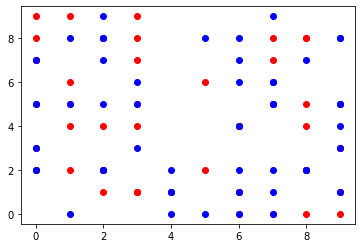

In [108]:
# Não linear
X, y = generate_data(100)
p = Perceptron(eta=0.5, n_iter=100)
p.fit(X, y)
y_pred = p.predict([[4, 7],[4, 0],[0, 7],[0, 0], [1,2]])
print(y_pred)
plot(X, y)

[-1  1  1  1  1]


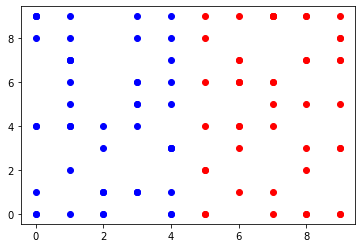

1.0


In [106]:
# Linear
Xl, yl = generate_data(100, linear=True)
p = Perceptron(eta=0.5, n_iter=100)
p.fit(Xl, yl)
yl_pred = p.predict([[6, 5],[4, 0],[0, 7],[0, 0], [1,2]])
print(yl_pred)
plot(Xl, yl)
print(accuracy(yl_pred, [-1,1,1,1, 1]))

In [109]:
p = Perceptron(eta=0.5, n_iter=10)
p.fit(Xl, yl)
p.predict([[4, 7]])

array([1])

## Questao 3 - Treine um classificador perceptron para os dados de seu estudo de caso

### Objetivo:
* Criar uma função que ajuste os dados: dado um esporte elimine colunas desnecessárias para o aprendizado e adicione uma nova coluna target onde ela terá valor 1 (se o atleta praticar o determinado esporte) e 0 (caso contrário). As features que desejamos manter para o aprendizado são Sexo, Idade, Altura, Peso e Equipe.

In [40]:
df = pd.read_csv('../datasets/athlete_events.csv')
df.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Primeiramente vamos remover todos os dados duplicados e NaN nas colunas que são importantes:

In [14]:
_df = df.drop_duplicates(subset='ID', keep="first") #eliminando duplicatas
_df = _df.dropna(axis=0, subset=['Height', 'Weight', 'Age', 'Sex', 'Team']) #eliminando dados NaN

Agora, precisamos remover as colunas com features que não iremos precisar para o modelo:

In [15]:
df_proc = _df.drop(columns=['Name','Year', 'NOC', 'Games', 'Season', 'City', 'Event', 'Medal', 'Team'])
df_proc

,ID,Sex,Age,Height,Weight,Sport
0,1,M,24.0,180.0,80.0,Basketball
1,2,M,23.0,170.0,60.0,Judo
4,5,F,21.0,185.0,82.0,Speed Skating
10,6,M,31.0,188.0,75.0,Cross Country Skiing
18,7,M,31.0,183.0,72.0,Cross Country Skiing
...,...,...,...,...,...,...
271108,135567,M,24.0,183.0,72.0,Rowing
271110,135568,F,33.0,171.0,69.0,Basketball
271111,135569,M,29.0,179.0,89.0,Luge
271112,135570,M,27.0,176.0,59.0,Ski Jumping


In [115]:
t_sport = 'Judo'
#df_sport = df_proc.loc[df_proc['Sport'] == t_sport]
df_sport = df_proc.copy()
df_sport['Target'] = (df_sport['Sport'] == t_sport).astype(int)
df_sport['Target'] = df_sport['Target'].replace([0],-1)
#df_sport = df_sport.loc[df_proc['Sport'] == t_sport]
df_sport

,ID,Sex,Age,Height,Weight,Sport,Target
0,1,M,24.0,180.0,80.0,Basketball,-1
1,2,M,23.0,170.0,60.0,Judo,1
4,5,F,21.0,185.0,82.0,Speed Skating,-1
10,6,M,31.0,188.0,75.0,Cross Country Skiing,-1
18,7,M,31.0,183.0,72.0,Cross Country Skiing,-1
...,...,...,...,...,...,...,...
271108,135567,M,24.0,183.0,72.0,Rowing,-1
271110,135568,F,33.0,171.0,69.0,Basketball,-1
271111,135569,M,29.0,179.0,89.0,Luge,-1
271112,135570,M,27.0,176.0,59.0,Ski Jumping,-1


In [116]:
df_sport['Sex'] = (df_sport['Sex'] == 'F').astype(int)
df_sport = df_sport.drop(columns = ['Sport'])
df_sport

,ID,Sex,Age,Height,Weight,Target
0,1,0,24.0,180.0,80.0,-1
1,2,0,23.0,170.0,60.0,1
4,5,1,21.0,185.0,82.0,-1
10,6,0,31.0,188.0,75.0,-1
18,7,0,31.0,183.0,72.0,-1
...,...,...,...,...,...,...
271108,135567,0,24.0,183.0,72.0,-1
271110,135568,1,33.0,171.0,69.0,-1
271111,135569,0,29.0,179.0,89.0,-1
271112,135570,0,27.0,176.0,59.0,-1


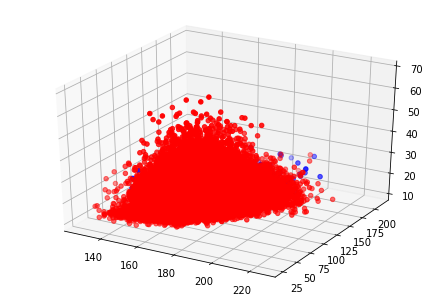

In [118]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)


df_target = df_sport.loc[df_sport['Target'] == 1]
df_out_target = df_sport.loc[df_sport['Target'] == -1]

ax.scatter(df_target['Height'], df_target['Weight'], df_target['Age'], c='blue')
ax.scatter(df_out_target['Height'], df_out_target['Weight'], df_out_target['Age'], c='red')

#plt.scatter(df_out_target['Height'], df_out_target['Weight'], df_out_target['Age'], c='red', alpha=0.2)
#plt.scatter(df_target['Height'], df_target['Weight'], df_target['Age'] c='blue', alpha=0.2)

plt.show()

In [128]:
tam = len(df_sport)
limite = math.floor(0.6 * tam)
X_train, y_train = df_sport[0:limite].drop(columns = ['ID','Target']), df_sport[0:limite].drop(columns = ['ID', 'Sex', 'Age', 'Height', 'Weight'])
X_test, y_test = df_sport[limite:tam].drop(columns = ['ID','Target']), df_sport[limite:tam].drop(columns = ['ID', 'Sex', 'Age', 'Height', 'Weight'])
X_test

,Sex,Age,Height,Weight
163161,0,42.0,185.0,77.0
163163,0,26.0,178.0,72.0
163164,0,24.0,172.0,76.0
163167,1,25.0,165.0,57.0
163169,0,21.0,172.0,78.0
...,...,...,...,...
271108,0,24.0,183.0,72.0
271110,1,33.0,171.0,69.0
271111,0,29.0,179.0,89.0
271112,0,27.0,176.0,59.0


In [144]:
ppc = Perceptron(eta=0.5, n_iter=10)
ppc.fit(X_train.values, y_train.values)

In [145]:
y_pred = ppc.predict(X_test.values)
accuracy(y_pred, np.concatenate(y_test.values).ravel().tolist())

0.9757291351296801

In [146]:
print(y_pred, '\n', np.concatenate(y_test.values).ravel().tolist())

[-1 -1 -1 ... -1 -1 -1] 
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1

In [147]:
y_pred = ppc.predict([0, 30.0, 170.0, 60])
y_pred

array(-1)